In [ ]:
import numpy as np
import regex as re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
import math
import os

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras.backend as K
import tokenizers
from transformers import RobertaTokenizer, TFRobertaModel,BertTokenizerFast, BertForSequenceClassification

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install transformers

     |████████████████████████████████| 3.4 MB 5.3 MB/s 
     |████████████████████████████████| 895 kB 61.2 MB/s 
     |████████████████████████████████| 596 kB 67.8 MB/s 
     |████████████████████████████████| 3.3 MB 14.8 MB/s 
     |████████████████████████████████| 67 kB 1.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
!pip install pytorch-transformers

In [ ]:
## PyTorch Transformer
from pytorch_transformers import RobertaModel, RobertaTokenizer
from pytorch_transformers import RobertaForSequenceClassification, RobertaConfig

In [ ]:
# Detect hardware, return appropriate distribution strategy (you can see that it is pretty easy to set up).
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set (always set in Kaggle)
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    print('Running on TPU ', tpu.master())
except ValueError:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print('Number of replicas:', strategy.num_replicas_in_sync)

In [ ]:
MODEL_NAME = 'roberta-base'
MAX_LEN = 256
ARTIFACTS_PATH = '../artifacts/'

BATCH_SIZE = 8 * strategy.num_replicas_in_sync
EPOCHS = 3

if not os.path.exists(ARTIFACTS_PATH):
    os.makedirs(ARTIFACTS_PATH)

In [ ]:
! gdown --id 1etLBrBTdokVHIuaxEmr1Koacos4IbMZL ## ConsumerComplaints
#! gdown --id 1LxH5sC6AdrwzClPEGUAV2HVcPjWIPmc8  ##SupportTickets
#! gdown --id 1RbjMCyW0_P8RbW0BG2Sc6hX6wkAChnXq ## Non-Pre-processed Support Tickets
#! gdown --id 1IJ0tiXquZucrnafH2otIIgheVdLih7TQ  ##BBC
#! gdown --id 1-xy_b8JP_Co4MKgRx3yjxWYkamT0Dup4  ##20news


Downloading...
From: https://drive.google.com/uc?id=1etLBrBTdokVHIuaxEmr1Koacos4IbMZL
To: /content/ProcessedConsumerData.csv
100% 2.24G/2.24G [00:22<00:00, 99.9MB/s]


In [ ]:
import pandas as pd
import io
data = pd.read_csv('ProcessedConsumerData.csv')

In [ ]:
from sklearn.datasets import fetch_20newsgroups
dataset_full = fetch_20newsgroups(subset='all',  shuffle=True, random_state=42)

In [ ]:
df_full = pd.DataFrame()
df_full['text'] = dataset_full.data
df_full['source'] = dataset_full.target
label=[]
for i in df_full['source']:
    label.append(dataset_full.target_names[i])
df_full['label']=label

In [ ]:
data.head()

In [ ]:
data.drop(data.columns[data.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)
#data.head(5)

In [ ]:
##  Creating a new Dataframe with the cols we're interested In
#cols = ['text', 'label']
cols = ['TokenizedText', 'Product']
data = data[cols]
data.head(10)

In [ ]:
X_data = data[['TokenizedText']].to_numpy().reshape(-1)
y_data = data[['Product']].to_numpy().reshape(-1)

#X_data = data[['TokenizedText']].to_numpy().reshape(-1)
#y_data = data[['Product']].to_numpy().reshape(-1)


In [ ]:
X_data.shape

(2225,)

In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(str(text))

        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])

        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN

        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')

        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
# Transform categories into numbers
category_to_id = {}
category_to_name = {}

for index, c in enumerate(y_data):
    if c in category_to_id:
        category_id = category_to_id[c]
    else:
        category_id = len(category_to_id)
        category_to_id[c] = category_id
        category_to_name[category_id] = c

    y_data[index] = category_id

# Display dictionary
category_to_name

In [ ]:
categories = data['Product'].unique()
n_categories = len(categories)

In [ ]:
n_categories

15

In [ ]:
# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=777) # random_state to reproduce results

In [ ]:
X_train.shape

(136217,)

In [ ]:
# Import tokenizer from HuggingFace
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)

In [ ]:
X_train = roberta_encode(X_train, tokenizer)
X_test = roberta_encode(X_test, tokenizer)

y_train = np.asarray(y_train, dtype='int32')
y_test = np.asarray(y_test, dtype='int32')

In [ ]:
X_train

In [ ]:
def build_model(n_categories):
    with strategy.scope():
        input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
        input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
        input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

        # Import RoBERTa model from HuggingFace
        roberta_model = TFRobertaModel.from_pretrained(MODEL_NAME)
        x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

        # Huggingface transformers have multiple outputs, embeddings are the first one,
        # so let's slice out the first position
        x = x[0]

        x = tf.keras.layers.Dropout(0.1)(x)
        x = tf.keras.layers.Flatten()(x)
        x = tf.keras.layers.Dense(256, activation='relu')(x)
        x = tf.keras.layers.Dense(n_categories, activation='softmax')(x)

        model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
        model.compile(
            optimizer=tf.keras.optimizers.Adam(lr=1e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy'])

        return model

In [ ]:
with strategy.scope():
    model = build_model(n_categories)
    model.summary()

Some layers from the model checkpoint at roberta-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at roberta-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 256)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 256)]        0           []                               
                                                                                                  
 tf_roberta_model (TFRobertaMod  TFBaseModelOutputWi  124645632  ['input_word_ids[0][0]',         
 el)                            thPoolingAndCrossAt               'input_mask[0][0]',         

In [ ]:
with strategy.scope():
    print('Training...')
    history = model.fit(X_train,
                        y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        verbose=1,
                        validation_data=(X_test, y_test))

Training...
Epoch 1/3


INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int32>]


Instructions for updating:
use `experimental_local_results` instead.


Instructions for updating:
use `experimental_local_results` instead.
INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int32>]


6238/6238 [==============================] - ETA: 0s - loss: 0.5611 - accuracy: 0.8111

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond/Identity:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond/Identity_8:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond/Identity_16:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond/Identity_24:0' shape=(None,) dtype=int32>]


6238/6238 [==============================] - 1292s 194ms/step - loss: 0.5611 - accuracy: 0.8111 - val_loss: 0.4859 - val_accuracy: 0.8327
Epoch 2/3
6238/6238 [==============================] - 1140s 183ms/step - loss: 0.4534 - accuracy: 0.8430 - val_loss: 0.4496 - val_accuracy: 0.8440
Epoch 3/3
6238/6238 [==============================] - 1141s 183ms/step - loss: 0.3821 - accuracy: 0.8658 - val_loss: 0.4485 - val_accuracy: 0.8469


In [ ]:
def plot_confusion_matrix(X_test, y_test, model):
    y_pred = model.predict(X_test)
    y_pred = [np.argmax(i) for i in model.predict(X_test)]

    con_mat = tf.math.confusion_matrix(labels=y_test, predictions=y_pred).numpy()

    con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
    label_names = list(range(len(con_mat_norm)))

    con_mat_df = pd.DataFrame(con_mat_norm,
                              index=label_names,
                              columns=label_names)

    figure = plt.figure(figsize=(10, 10))
    sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

INFO:absl:TPU has inputs with dynamic shapes: [<tf.Tensor 'Const:0' shape=() dtype=int32>, <tf.Tensor 'cond_8/Identity:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond_8/Identity_1:0' shape=(None, 256) dtype=int32>, <tf.Tensor 'cond_8/Identity_2:0' shape=(None, 256) dtype=int32>]


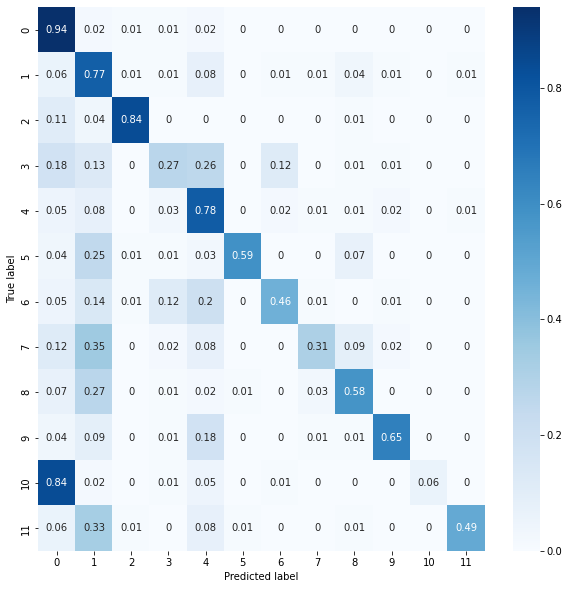

In [ ]:
plot_confusion_matrix(X_test, y_test, model)


In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

NameError: ignored